# Categorical variables: optimizing neural network with TensorFlow and Emukit

This notebook is going to illustrate how to use categorical variables with Emukit.

In [1]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Necessary imports
import tensorflow as tf
import GPy

from emukit.core import ContinuousParameter, DiscreteParameter, ParameterSpace, CategoricalParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

For this example we are going to optimize a very simple neural network built with TensorFlow. We will reuse the very first example of [how to use TensorFlow](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb) with number of epochs reduced to 1 in the interest of saving time. We are going to consider two hyper parameters that are going to be subjects of optimization:
* Type of optimizer. We are going to choose from Adam, AdaGrad and SGD. This is clearly a categorical parameter.
* Dropout rate, ranging between 0.05 and 0.95. This parameter is continuous.  

Here is the definition of the function we are going to optimize:

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 

def eval_model(dropout_rate, optimizer):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dropout(dropout_rate),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=1)
    loss, accuracy = model.evaluate(x_test, y_test)
    
    return accuracy

Emukit takes both objective and model as inputs. So when users come to Emukit it is expected that they have already done necessary conversions to turn categorical parameters into numerical values. If that is the case, users should create a DiscreteParameter object with numerical values as the domain. If that is not the case yet, Emukit can generate [one-hot encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding).

Emukit provides a convenience method for both cases, which takes optinal encodings if they are already created. In this example we will use Emukit to generate encodings for us.

In [4]:
space = ParameterSpace([
    ContinuousParameter('dropout_rate', 0.05, 0.95),
    CategoricalParameter('optimizer', np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]))
])

We can use random forest as our model, which comes in Emukit's examples package. Notice that you need Scikit-learn installed to be able to use it:

In [5]:
from emukit.examples.models.random_forest import RandomForest

encoding_to_cat = {(1,0,0): 'adam', (0,1,0):'adagrad', (0,0,1):'sgd'}

X_init = np.array([[0.9, 1, 0, 0], [0.3, 0, 0, 1], [0.75, 1, 0, 0]])
#Y_init = np.array([[eval_model(x[0], encoding_to_cat[x[1]])] for x in X_init])
Y_init = np.array([[0.966 ],[0.9094],[0.9681]])

rf_model = RandomForest(X_init, Y_init)

Let's examine the returned data:

In [6]:
Y_init

array([[0.966 ],
       [0.9094],
       [0.9681]])

Emukit requires objective function to accept 2d array as an input, and it also expects model and objective function to accept input of the same form. It is not the case with our objective yet: it declares input parameters explicitly, and expects optimizer name instead of encoding value. Let's fix it. This is where mappings we obtained before may come handy:

In [7]:
def emukit_friendly_objective_function(input_rows):
    output = []
    for row in input_rows:
        print(row)
        dropout_rate = row[0]
        optimizer = encoding_to_cat[tuple(row[1:].astype(int).tolist())]
        print(dropout_rate)
        print(optimizer)
        eval_result = eval_model(dropout_rate, optimizer)
        output.append([eval_result])
    
    return np.array(output)

At this point everything is ready to run the optimization loop.

In [8]:
loop = BayesianOptimizationLoop(rf_model, space)
loop.run_loop(emukit_friendly_objective_function, 10)

[0.06409119 0.         1.         0.        ]
0.06409119253494487
adagrad
Epoch 1/1
10000/10000 [==============================] - 1s 144us/step
[0.48958783 1.         0.         0.        ]
0.4895878290419129
adam
Epoch 1/1
10000/10000 [==============================] - 1s 109us/step
[0.29035148 0.         0.         1.        ]
0.29035148123391175
sgd
Epoch 1/1
10000/10000 [==============================] - 1s 133us/step
[0.29450534 0.         0.         1.        ]
0.2945053384953453
sgd
Epoch 1/1
10000/10000 [==============================] - 1s 110us/step
[0.60651183 0.         0.         1.        ]
0.6065118345958654
sgd
Epoch 1/1
10000/10000 [==============================] - 1s 105us/step
[0.15222698 0.         0.         1.        ]
0.15222697771843285
sgd
Epoch 1/1
10000/10000 [==============================] - 1s 103us/step
[0.76982934 0.         0.         1.        ]
0.7698293439528807
sgd
Epoch 1/1
10000/10000 [==============================] - 1s 97us/step
[0.79317675 0

Let's plot the results of the optimization run.

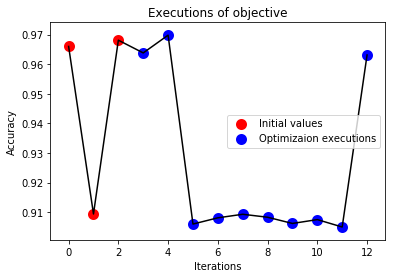

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title('Executions of objective')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(range(loop.loop_state.Y.shape[0]), loop.loop_state.Y[:, 0], c='k')
plt.scatter(range(3), loop.loop_state.Y[:3, 0], c='r', linewidths=5, label="Initial values")
plt.scatter(range(3, loop.loop_state.Y.shape[0]), loop.loop_state.Y[3:, 0], c='b', linewidths=5, label="Optimizaion executions")
plt.legend();